In [6]:
 pip install medmnist

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import medmnist
import torch.utils.data as data
from medmnist import INFO, Evaluator
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [80]:
# Load the dataset
data_flag = 'octmnist' #dataset which will be using
download = True #whether to download the dataset or not

In [81]:
NUM_EPOCHS = 10 #Number of training epochs
info = INFO[data_flag]
BATCH_SIZE = 128 #Batch size for train and valid
LEARNING_RATE = 0.001 #Learning rate for the optimizer
WEIGHT_DECAY = 1e-4 #L2 regularization
PATIENCE = 5  # for early stopping# Load the data
DataClass = getattr(medmnist, info['python_class'])
MODEL_PATH = 'best_model.pth' #path to save the model
n_channels = info['n_channels'] #initializing number of channels and classes
n_classes = len(info['label'])

In [82]:
# Load the data
DataClass = getattr(medmnist, info['python_class'])

In [83]:
# Define the transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [84]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: C:\Users\raksh\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\raksh\.medmnist\octmnist.npz
Using downloaded and verified file: C:\Users\raksh\.medmnist\octmnist.npz


In [85]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [86]:
train_dataset

Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 97477
    Root location: C:\Users\raksh\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [87]:
test_dataset

Dataset OCTMNIST of size 28 (octmnist)
    Number of datapoints: 1000
    Root location: C:\Users\raksh\.medmnist
    Split: test
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0

In [88]:
# visualization

train_dataset.montage(length=1)

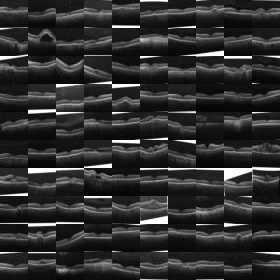

In [89]:
# montage

train_dataset.montage(length=10)

In [90]:
# Define a CNN model
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1), ## 1st convolutional layer with 16 filters
            nn.BatchNorm2d(16), # # Batch normalization to speed the training
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling to downsample the feature maps
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),# 2nd convolutional layer with 32 filters
            nn.BatchNorm2d(32), #batch
            nn.ReLU(), #Relu
            nn.MaxPool2d(kernel_size=2, stride=2) #Max pooling
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 3rd convolutional layer with 64 filters
            nn.BatchNorm2d(64), #Batch
            nn.ReLU(), #Relu
            nn.MaxPool2d(kernel_size=2, stride=2) #Max Pooling
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128), # Fully connected layer with 128 output neurons
            nn.ReLU(),
            nn.Dropout(0.5) # Dropout regularization with a dropout probability of 0.5 (hyperparameter)
        )
        #Hyperparameters such as dropout probability (0.5)  
        #are a regularization technique that helps prevent overfitting by randomly setting a fraction of input units 
        #to zero during training. 
        #A dropout probability of 0.5 means that each neuron in the dropout layer has a 50% chance of being dropped out during training. 
        #Adjusting this probability can affect the model's performance and generalization ability.
        self.fc2 = nn.Linear(128, num_classes) # Output layer with num_classes output neurons

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1) # Flatten the output for the fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        return x
#initializing the CNN model
model = CNN(in_channels=n_channels, num_classes=n_classes)

In [91]:
# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss() #cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) #adam optimizer

In [92]:
# Training function with early stopping and model saving
def train(model, train_loader, val_loader, criterion, optimizer, epochs=NUM_EPOCHS, patience=PATIENCE):
    # Initialize variables for early stopping
    best_val_loss = float('inf') # Set the initial best validation loss to infinity
    patience_counter = 0 # Initialize patience counter for early stopping
    history = { # Dictionary to store training history
        'train_loss': [],  # Training loss for each epoch
        'val_loss': [],  # Validation loss for each epoch
        'train_accuracy': [], # Training accuracy for each epoch
        'val_accuracy': [] # Validation accuracy for each epoch
    }
# Iterate over the specified number of epochs
    for epoch in range(epochs):
        model.train() #setting model to train mode
        running_loss = 0.0 # Initialize running loss for the current epoch
        correct = 0 # Initialize the number of correct predictions
        total = 0
         # Iterate over the batches in the training dataset
        for inputs, targets in tqdm(train_loader): #iterating over the training datasets
            optimizer.zero_grad() #zeroing the parameter gradients
            outputs = model(inputs) #forward pass 
            loss = criterion(outputs, targets.squeeze().long()) #computing the loss
            loss.backward() #initializing backward loss
            optimizer.step() #optimize
            running_loss += loss.item()
            _, predicted = outputs.max(1)# Get the predicted class labels
            total += targets.size(0) # Update the total number of predictions
            correct += predicted.eq(targets.squeeze().long()).sum().item() # Count the correct predictions

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total  #computing training loss and accuracy

        # Validate
        model.eval()  #set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            # Iterate over the batches in the validation dataset
            for inputs, targets in val_loader: # Iterate over the validation dataset
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze().long())
                val_loss += loss.item() # Accumulate the loss
                _, predicted = outputs.max(1)
                total += targets.size(0) # Updating  the total number of predictions
                correct += predicted.eq(targets.squeeze().long()).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100. * correct / total #Compute validation loss and accuracy for current epoch

        history['train_loss'].append(train_loss)   # Update history for training
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Check for early stopping and save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss # Update the best validation loss
            best_model_wts = model.state_dict() # Save the current model state
            torch.save(best_model_wts, MODEL_PATH) # Save the best model to file
            patience_counter = 0 # Reset the patience counter
        else:
            patience_counter += 1 # Increment the patience counter
            if patience_counter >= patience:
                print("Early stopping triggered.") # Printing a message indicating early stopping
                break # Exit the training loop if early stopping criterion is met
    # Load the best model weights
    model.load_state_dict(torch.load(MODEL_PATH))
    return model, history # Return the trained model and training histor

In [93]:
# Train the model
model, history = train(model, train_loader, val_loader, criterion, optimizer, epochs=NUM_EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [04:03<00:00,  3.12it/s]


Epoch [1/10], Train Loss: 0.5381, Train Accuracy: 81.51%, Val Loss: 0.4038, Val Accuracy: 85.65%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [06:21<00:00,  2.00it/s]


Epoch [2/10], Train Loss: 0.4064, Train Accuracy: 86.04%, Val Loss: 0.4104, Val Accuracy: 85.35%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [05:29<00:00,  2.31it/s]


Epoch [3/10], Train Loss: 0.3657, Train Accuracy: 87.37%, Val Loss: 0.3176, Val Accuracy: 88.75%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [05:39<00:00,  2.24it/s]


Epoch [4/10], Train Loss: 0.3395, Train Accuracy: 88.18%, Val Loss: 0.2851, Val Accuracy: 89.95%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [04:23<00:00,  2.89it/s]


Epoch [5/10], Train Loss: 0.3158, Train Accuracy: 89.15%, Val Loss: 0.2991, Val Accuracy: 89.62%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [06:42<00:00,  1.89it/s]


Epoch [6/10], Train Loss: 0.3007, Train Accuracy: 89.56%, Val Loss: 0.3020, Val Accuracy: 89.19%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [05:49<00:00,  2.18it/s]


Epoch [7/10], Train Loss: 0.2880, Train Accuracy: 90.06%, Val Loss: 0.2447, Val Accuracy: 91.27%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [04:35<00:00,  2.77it/s]


Epoch [8/10], Train Loss: 0.2757, Train Accuracy: 90.51%, Val Loss: 0.3159, Val Accuracy: 88.74%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [06:20<00:00,  2.00it/s]


Epoch [9/10], Train Loss: 0.2629, Train Accuracy: 90.86%, Val Loss: 0.2482, Val Accuracy: 91.20%


100%|████████████████████████████████████████████████████████████████████████████████| 762/762 [07:10<00:00,  1.77it/s]


Epoch [10/10], Train Loss: 0.2535, Train Accuracy: 91.31%, Val Loss: 0.3155, Val Accuracy: 89.09%


In [95]:
# Test the model
def test(model, test_loader, criterion):
    # Set the model to evaluation mode
    model.eval()
     # Initialize variables for test evaluation
    test_loss = 0.0 # Initialize test loss
    correct = 0
    total = 0
    all_preds = []# List to store all true labels
    all_labels = [] # List to store all true labels
# Iterate over the batches in the test dataset
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs) #Forward pass
            loss = criterion(outputs, targets.squeeze().long())
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)  # Update the total number of predictions
            correct += predicted.eq(targets.squeeze().long()).sum().item()   # Extend the lists with predicted and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.squeeze().long().cpu().numpy())
# Compute average test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    return all_labels, all_preds, test_loss, test_accuracy

# Load the best model weights before testing
model.load_state_dict(torch.load(MODEL_PATH))

# Test the model
all_labels, all_preds, test_loss, test_accuracy = test(model, test_loader, criterion)


Test Loss: 0.6856, Test Accuracy: 73.20%


In [96]:
# Load the best model weights before testing
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [97]:
# Test the model
all_labels, all_preds, test_loss, test_accuracy = test(model, test_loader, criterion)

Test Loss: 0.6856, Test Accuracy: 73.20%


Text(0, 0.5, 'Accuracy')

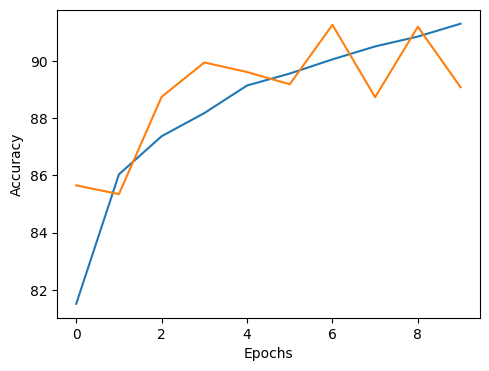

In [98]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

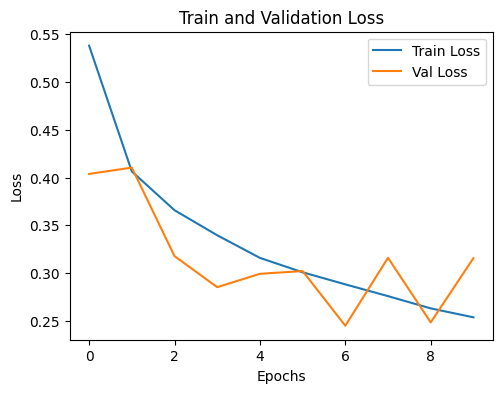

In [99]:
# Plot training and validation loss
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.show()

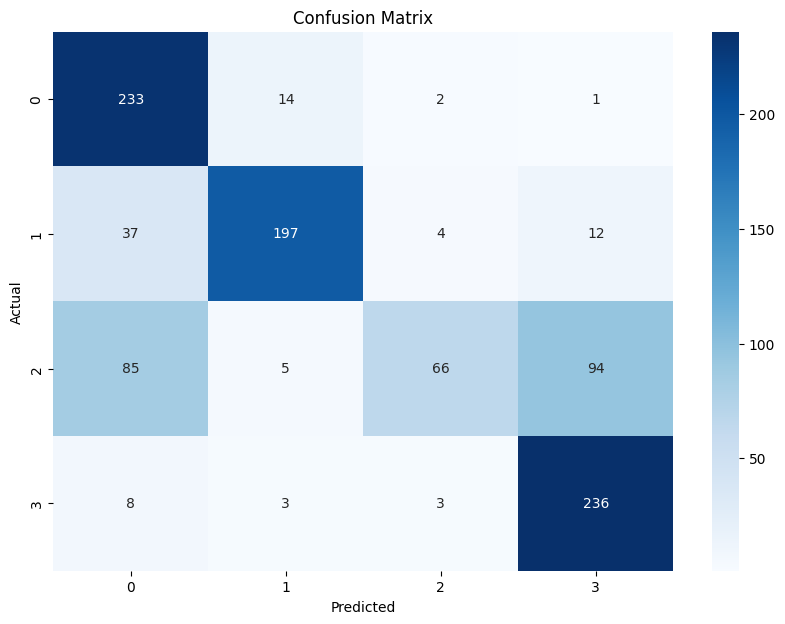

In [100]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'], yticklabels=info['label'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [101]:
# Calculate and report other evaluation metrics
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.7774
Recall: 0.7320
